In [1]:
import os
import ee
import datetime
import numpy as np
import rsfuncs as rs
import geopandas as gp
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

ee.Initialize()

In [2]:
def count_vertices(gdf):
    for i, row in gdf.iterrows():
    # It's better to check if multigeometry
        multi = row.geometry.type.startswith("Multi")

        if multi:
            n = 0
            # iterate over all parts of multigeometry
            for part in row.geometry:
                n += len(part.exterior.coords)
        else: # if single geometry like point, linestring or polygon
            n = len(row.geometry.exterior.coords)

    print(n)


65


/Users/aakashahamed/anaconda3/envs/water/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


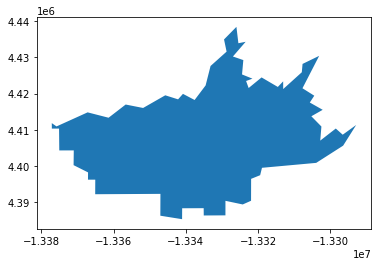

In [3]:
# Read shapefile 
gdf = gp.read_file("/Users/aakashahamed/Desktop/NKGSA.shp")
gdf.geometry = gdf.simplify(1000)
count_vertices(gdf)
gdf.plot()
area = rs.gdf_to_ee_poly(gdf)

# calc area 
tgdf = gdf.copy()
tgdf = tgdf.to_crs({'init': 'epsg:26910'})
area_m2 = tgdf.area
area_km2 = tgdf.area * 1e-6 # sq m to sq km
area_ac = area_km2 * 247.105 # sq km to acres 

In [4]:
data = rs.load_data()
prism = data['prism']

In [5]:
startdate = datetime.datetime.strptime('1997-10-01', "%Y-%m-%d")
enddate = datetime.datetime.strptime('2011-09-30', "%Y-%m-%d")

In [6]:
monthly_p = rs.calc_monthly_sum(data['prism'], startdate, enddate, area)

processing:
OREGONSTATE/PRISM/AN81m/189501


  0%|          | 0/168 [00:00<?, ?it/s]

In [7]:
monthly_p['in'] = monthly_p['ppt']*0.0393701 # mm to in 

In [8]:
monthly_p['af'] = monthly_p['in'] * area_ac.values / 12 # in to ft * acres = acre ft 

In [9]:
annual_df = monthly_p.resample("Y").mean()
afmean = str(round(annual_df['af'].mean(),2))
inmean = str(round(annual_df['in'].mean(),2))

Text(0.5, 1.0, '\nMean Annual PRISM Precip\nWY 1997 - 2011\nmean = 278701.96 AF\nmean = 10.72 in\n')

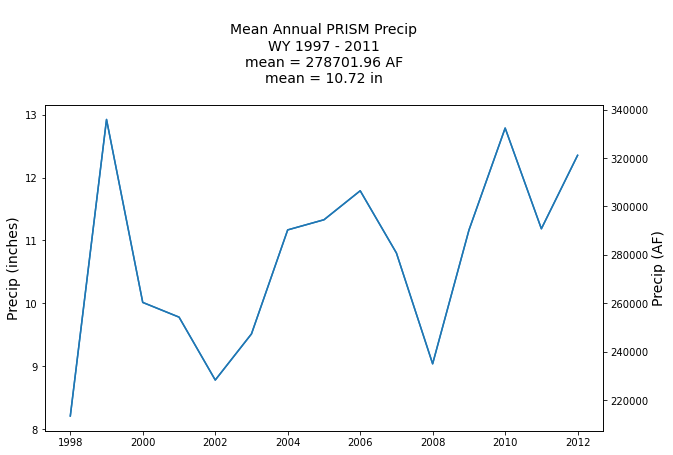

In [13]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(annual_df.index, annual_df['in'])
ax.set_ylabel("Precip (inches)", size = 14)
ax2 = ax.twinx()
ax2.plot(annual_df.index, annual_df['af'])
ax2.set_ylabel("Precip (AF)", size = 14)

plt.title('''
Mean Annual PRISM Precip
WY 1997 - 2011
mean = {} AF
mean = {} in
'''.format(afmean,inmean), size = 14)

In [11]:
annual_df.to_csv("/Users/aakashahamed/Desktop/NKGSA_precip.csv")